# GSPE Example File
This notebook runs HOPP and applies the correct power electronics efficency factors established in the Green Steel Power Electronics (GSPE) simulator

NOTE: all of the economic analysis will use the efficency factors that are default in PySAM/set in HOPP. The goal of this script is to solely return a power time series with the correct efficency factors.

In [9]:
from hopp.simulation import HoppInterface
import numpy as np

hi = HoppInterface('./inputs/08-GSPE.yaml')
hi.simulate(30)

print('simulation complete')

simulation complete


## Work on implementing new power electronic efficencies according to the GSPE code

1) revert efficency factors applied in HOPP

In [18]:
gen, annual_energy, capacity_factor = dict(), dict(),  dict()

# wind
wm = hi.hopp.system.technologies['wind']._system_model

if hi.hopp.system.technologies['wind'].config.model_name == 'floris':
    DEFAULT_PYSAM_LOSSES = 12.83
    gen['wind'] = wm.gen * ((100 - DEFAULT_PYSAM_LOSSES)/100) ** -1 # revert PySAM default losses
    annual_energy['wind'] = np.sum(gen['wind'])
    capacity_factor['wind'] = annual_energy['wind'] / (8760 * wm.system_capacity) * 100

else: # wm.config.model_name == 'pysam'
    non_wake_losses = 0
    pysam_losses_dict = wm.export()['Losses']

    # NOTE the below losses add to 12.83
    relevant_losses = ['avail_bop_loss', 'avail_grid_loss', 'avail_turb_loss', 'elec_eff_loss', 'elec_parasitic_loss', 
                        'env_degrad_loss', 'env_env_loss', 'env_exposure_loss', 'env_icing_loss', 'ops_env_loss', 
                        'ops_grid_loss', 'ops_load_loss', 'ops_strategies_loss']
    
    for losses in relevant_losses:
        non_wake_losses += pysam_losses_dict[losses]
    
    gen['wind'] = [i * ((100 - non_wake_losses)/100)**-1 for i in wm.Outputs.gen][:8760]
    annual_energy['wind'] = np.sum(gen['wind'])
    capacity_factor['wind'] = annual_energy['wind'] / (8760 * wm.Farm.system_capacity) * 100

# solar
pvm = hi.hopp.system.technologies['pv']._system_model

pysam_losses = ((100 - pvm.SystemDesign.inv_eff) + pvm.SystemDesign.losses) / 100

gen['pv'] = [i * 1e-3 for i in pvm.Outputs.dc] # pvm.Outputs.dc in W, convert to kW (dc power should be without losses applied)
annual_energy['pv'] = np.sum(gen['pv']) # hourly time series, result is in kWh
capacity_factor['pv'] = annual_energy['pv'] / (8760 * pvm.SystemDesign.system_capacity) * 100 # system capacity in kWh

# battery
# TODO assuming that battery never charges and discharges at the same time during any hour timestep
battery = hi.hopp.system.technologies['battery']

# NOTE negative powers coorespond to charging the battery
gen['battery'] = [p * battery.dispatch.charge_efficiency / 1e3 if p < 0 \
                  else p * battery.dispatch.discharge_efficiency / 1e3 \
                  for p in battery.generation_profile]

annual_energy['battery'] = np.sum(gen['battery'])
capacity_factor['battery'] = annual_energy['battery'] / (8760 * battery.system_capacity_kw) * 100

print('done')


done


2) calculate losses according to GSPE code (reference situation: DEFIG - H AC Coupled System 1)

*A few notes...*
* ignoring turbine-specific PE losses (assuming that those are already factored into the power time series)
*   i.e., starting analysis at up-transformer
* summing together wind and solar time series (TS) after the up-transformer
* applying down-transformer and rectifier losses to the combined power TS
* can extract power going in/out of the battery -- can then apply the relevant in/out power losses with the DC/DC converter

In [48]:
eff = {'back_to_back': 0.9604,
       'diode_based_rectifier': 0.96,
       'thyristor_based_rectifier': 0.992,
       'IGBT_based_inverter': 0.98,
       'bi_DCDC_converter': 0.985,
       'uni_DCDC_converter': 0.985,
       'transformer_up': 0.99,
       'transformer_down': 0.99,
       'rectifier_power_factor': 0.89,
       'transformer_power_factor': 0.85,
       } # from ORNL code

source_after_up_transformer = (np.array(gen['wind']) * eff['transformer_up']) + (np.array(gen['pv']) * eff['transformer_up'])
source_after_rectifier = source_after_up_transformer * eff['transformer_down'] * eff['diode_based_rectifier']

# NOTE assuming that we do not have to account for DC/AC converter, like we didn't account for the converters for the wind... 
# is this true?

battery_charging = np.array([-p * eff['bi_DCDC_converter'] if p < 0.0 else 0.0 for p in gen['battery']])
battery_discharging = np.array([p * eff['bi_DCDC_converter'] if p > 0.0 else 0.0 for p in gen['battery']])

power_to_electrolyzer = source_after_rectifier + battery_discharging - battery_charging

print('done')



done


### Some plots

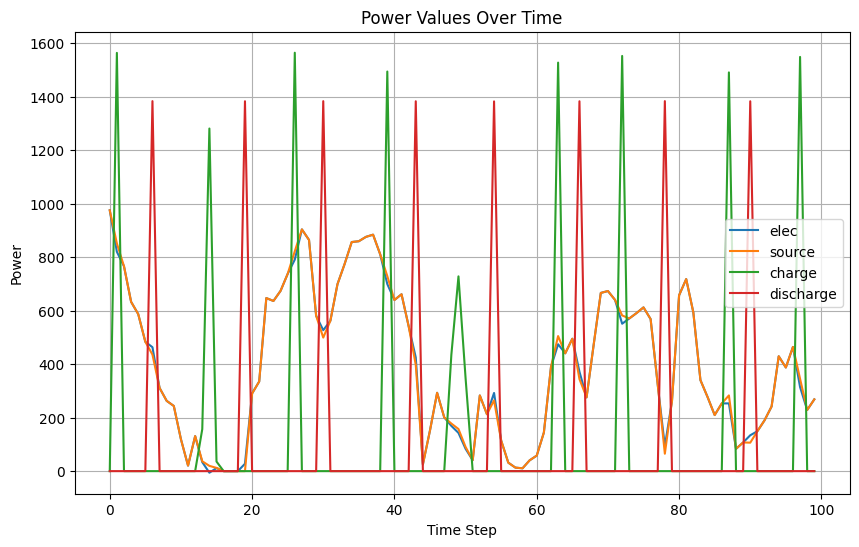

In [49]:
import matplotlib.pyplot as plt 

# Create an array of time steps (assuming one hour intervals)
time_steps = range(8760)[:100]

# Plot the power values against the time steps
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(time_steps, [i/5e1 for i in power_to_electrolyzer[900:1000]], label='elec') # divide by 10 so can view all the values on one set of axes
plt.plot(time_steps, [i/5e1 for i in source_after_rectifier[900:1000]],label='source')
plt.plot(battery_charging[900:1000], label='charge')
plt.plot(battery_discharging[900:1000], label='discharge')
# plt.plot(gen['battery'][200:300], label='gen')
plt.title('Power Values Over Time')
plt.xlabel('Time Step')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()

# TODO why is the power to electrolyzer going negative? Why is the battery charging when there is no source power? Looks like I mixed up
# charging and discharging

In [40]:
b = hi.system.technologies['battery']

dtot = b.generation_profile[len(b.generation_profile)-48:]
dtot = b.generation_profile[:48]
charge = b.dispatch.charge_power
dis = b.dispatch.discharge_power

distot = b.dispatch.power


dir(b.dispatch)

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_blocks',
 '_check_efficiency_value',
 '_check_initial_soc',
 '_create_capacity_parameter',
 '_create_efficiency_parameters',
 '_create_lifecycle_count_constraint',
 '_create_lifecycle_model',
 '_create_soc_inventory_constraint',
 '_create_soc_linking_constraint',
 '_create_storage_constraints',
 '_create_storage_parameters',
 '_create_storage_port',
 '_create_storage_variables',
 '_financial_model',
 '_lifecycle_count_rule',
 '_model',
 '_set_control_mode',
 '_set_model_specific_parameters',
 '_system_model',
 'block_set_name',
 'blocks',
 'capacity',
 'charge_efficiency',
 'charge_power',
 'control_